<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024Project/blob/grupowania-kowalski/colabs/t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup środowiska


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/PiotrMaciejKowalski/BigData2024Project.git
#%cd BigData2024Project
#!git checkout your-branch
#%cd ..

Cloning into 'BigData2024Project'...
remote: Enumerating objects: 1877, done.
remote: Counting objects: 100% (579/579), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 1877 (delta 442), reused 286 (delta 264), pack-reused 1298
Receiving objects: 100% (1877/1877), 69.33 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (1054/1054), done.
Updating files: 100% (149/149), done.


In [3]:
!chmod 755 /content/BigData2024Project/src/setup.sh
!/content/BigData2024Project/src/setup.sh
!pip install datashader
!pip install holoviews hvplot colorcet
!pip install geoviews

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 30.9 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.1.0
    Uninstalling platformdirs-4.1.0:
      Successfully uninstalled platformdirs-4.1.0
  Attempting uninstall: keyring
    Found existing installation: keyring 23.5.0
    Uninstallin

In [4]:
import sys
sys.path.append('/content/BigData2024Project/src')

In [5]:
from start_spark import initialize_spark
initialize_spark()

# Wczytanie danych

In [6]:
import pandas as pd
from pyspark.sql import SparkSession

from big_mess.loaders import default_loader, load_single_month, load_anotated, save_to_csv, preprocessed_loader

In [7]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [8]:
NASA_an = pd.read_csv('/content/drive/MyDrive/BigMess/NASA/NASA_an.csv',sep=';')
NASA_an["pustynia_i_step"] = NASA_an["pustynia"] + NASA_an["step"]

In [10]:
nasa_202305 = load_single_month(spark, year=2023, month=5).toPandas()
nasa_202306 = load_single_month(spark, year=2023, month=6).toPandas()
nasa_202307 = load_single_month(spark, year=2023, month=7).toPandas()
nasa_202308 = load_single_month(spark, year=2023, month=8).toPandas()
nasa_202309 = load_single_month(spark, year=2023, month=9).toPandas()

# Eksperymenty

In [118]:
NASA_an

,lon,lat,pustynia,step,pustynia_i_step
0,-98.4375,49.0625,0,0,0
1,-84.4375,51.9375,0,0,0
2,-100.5625,47.0625,0,0,0
3,-104.6875,48.8125,0,0,0
4,-95.1875,36.5625,0,0,0
...,...,...,...,...,...
1190,-108.0625,42.8125,0,0,0
1191,-103.1875,51.5625,0,0,0
1192,-88.8125,51.5625,0,0,0
1193,-120.5625,51.3125,0,0,0


In [120]:
from sklearn.model_selection import train_test_split

target = 'pustynia'
X = NASA_an[['lon', 'lat']]
y = NASA_an[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.16, stratify=y, random_state=42)


In [121]:
import pandas as pd
data = nasa_202307
data_columns = [column for column in data.columns if column not in ('lon', 'lat', 'Year', 'Month')]
X_train = pd.merge(X_train, data.drop(columns = ['Year', 'Month']), on=['lon', 'lat'], how='inner')
X_test = pd.merge(X_test, data.drop(columns = ['Year', 'Month']), on=['lon', 'lat'], how='inner')

In [122]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train[data_columns] = scaler.fit_transform(X_train[data_columns])
X_test[data_columns] = scaler.transform(X_test[data_columns])

In [124]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

n_components = 2
dim_reduction = PCA(n_components = n_components, random_state=2024)
reduction_columns= [f'reduction-{n}' for n in range(n_components)]
X_train[reduction_columns] = dim_reduction.fit_transform(X_train[data_columns])
X_test[reduction_columns] = dim_reduction.transform(X_test[data_columns])

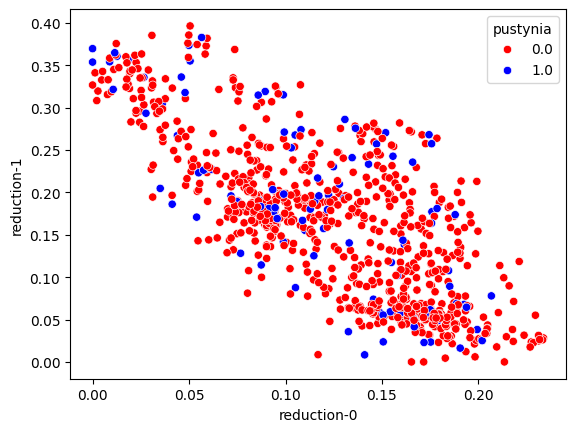

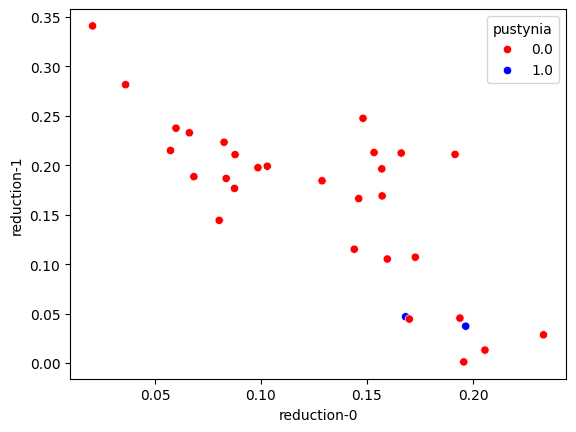

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=X_train[reduction_columns[0]], y=X_train[reduction_columns[1]], hue=y_train, palette = ["red", "blue"])
plt.show()
sns.scatterplot(x=X_test[reduction_columns[0]], y=X_test[reduction_columns[1]], hue=y_test, palette = ["red", "blue"])
plt.show()